In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

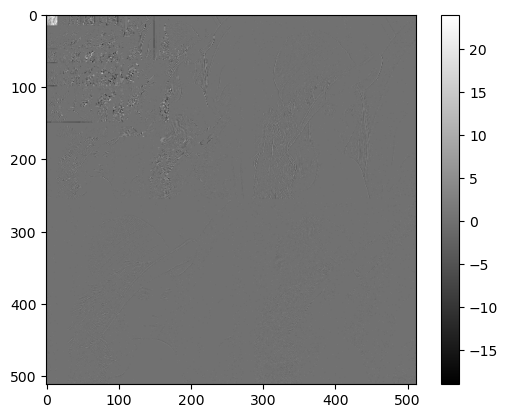

In [2]:
# load image
img = np.load('l5_decomp_quant.npy')
plt.imshow(img, cmap='gray')
plt.colorbar()

In [3]:
# create a EZW tree class
class EZWTree:
    def __init__(self, value, level, quadrant, coordinates, children, parent):
        self.value = value
        self.level = level
        self.children = children if children is not None else []
        self.quadrant = quadrant
        self.coordinates = coordinates
        self.ezwcode = None
        self.parent = parent if parent is not None else None
    
def build_tree(image, level=0, coordinates=(1,0), quadrant=None, parent=None):
    i, j = coordinates
    # Base case: if the coordinates are out of the image boundary, return None
    if i >= image.shape[0] or j >= image.shape[1]:
        return None

    # create the list of children coordinates / quadrant 2,1,3,4
    child_coordinates = [(2*i, 2*j), (2*i, 2*j+1), (2*i + 1, 2*j), (2*i + 1, 2*j + 1)]

    node = EZWTree(image[i, j], level, quadrant, coordinates, children=[], parent=parent)

    # recursively create the children
    for coord in child_coordinates:
        ci, cj = coord
        # Check if the child coordinates are within the image boundary
        if ci < image.shape[0] and cj < image.shape[1]:
            child = build_tree(image, level+1, coord, quadrant, parent=node)
            node.children.append(child)

    return node

In [4]:
# enumerate the img[0,16:0,16]
root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = build_tree(img, 1, (i,j+16), 1, None)
        child_3 = build_tree(img, 1, (i+16,j), 3, None)
        child_4 = build_tree(img, 1, (i+16,j+16), 4, None)
        root_nodes[i][j] = EZWTree(img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = root_nodes[i][j] # type: ignore
        child_3.parent = root_nodes[i][j] # type: ignore
        child_4.parent = root_nodes[i][j] # type: ignore

## Set ezw code

- P non-zero
- Z isolated zero
- T zero tree root

In [5]:
def dfs_set_value(node):
    # base case: if node is None, return False
    if node is None:
        return False

    # first process the children
    children_significant = [dfs_set_value(child) for child in node.children]

    # process the current node
    if np.abs(node.value) != 0:
        node.ezwcode = 'P' #Positive or negative non-zero
        return True
    else:
        # does code have significant descendant?
        if any(children_significant):
            node.ezwcode = 'Z' #Isolated zero
            return True
        else:
            node.ezwcode = 'T' #ZTR
            return False

In [6]:
def bfs_encode_list(root):
    # use BFS to traverse the tree
    queue = root.children.copy()
    dominant_pass_result = []
    while queue:
        node = queue.pop(0)
        # check ezwcode
        # check if the node is significant
        if node.ezwcode == 'P':
            dominant_pass_result.append(int(node.value))
        elif node.ezwcode == 'Z':
            dominant_pass_result.append(int(node.value))
        elif node.ezwcode == 'T':
            dominant_pass_result.append(node.ezwcode)
            continue
        # add the children to the queue
        if node.children:
            queue.extend(node.children)
    return dominant_pass_result

In [7]:
def transverse_encode(root):
    # use DFS to traverse the tree and set the ezwcode
    dfs_set_value(root)
    # use BFS to export the dominant_pass_result
    dominant_pass_result = bfs_encode_list(root)
    return dominant_pass_result


In [8]:
def enc_dp_sp(root_nodes_list):
    dpr_list = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            dpr_list[i][j] = transverse_encode(root_nodes_list[i][j])
            # print('coor', root_nodes_list[i][j].coordinates, 'done')
    return dpr_list

In [9]:
dpr_list= enc_dp_sp(root_nodes) # accuracte case is int(np.log2(threshold_enc_dec))+1

In [10]:
for i in range(0, 16):
    for j in range(0, 16):
        print(len(dpr_list[i][j]))

367
607
623
423
635
395
275
315
343
511
415
287
455
503
383
555
467
567
723
415
511
507
699
671
431
443
447
367
411
559
583
467
535
615
631
511
651
759
919
903
619
639
371
423
339
555
555
587
403
371
471
471
699
855
867
803
583
403
471
499
575
631
663
403
603
335
495
643
843
859
811
799
683
587
651
551
511
699
591
363
487
235
459
615
967
799
863
891
895
743
367
531
839
679
307
267
431
307
515
483
875
875
919
911
763
483
651
739
563
483
271
239
371
399
539
587
879
975
887
827
723
335
435
743
567
299
259
195
347
299
463
855
971
859
879
647
843
395
747
731
555
263
275
235
367
219
687
959
883
911
863
243
207
267
375
763
503
283
331
123
411
223
755
939
975
959
715
203
255
583
587
703
319
359
263
135
387
327
823
895
987
679
643
451
271
607
671
703
283
315
239
139
551
399
867
907
987
815
591
647
239
275
659
711
383
435
299
591
583
335
763
863
935
963
699
515
207
171
171
639
359
399
395
431
579
299
803
767
987
831
571
399
123
167
203
411
471
519
531
503
487
375
827
895
987
783
423
219
167
227


## run size encoding

In [11]:
# def run_size_single_list(input_list):
#     result = []
#     tmp_encode_list = []
#     while input_list:
#         first = input_list.pop(0)
#         if first == "T" and len(tmp_encode_list)<15:
#             tmp_encode_list.append(first)
#         else:
#             tmp_encode_list.append(first)
#             zeros_before_T = len(tmp_encode_list) - 1
#             # append (run,size) to result
#             result.append((zeros_before_T, tmp_encode_list[-1]))
#             tmp_encode_list = []
#     return result


## Size amplitude representation

### convert to unsigned bin

In [12]:
def convert_to_bin(num, bin_len):
    if num >= 0:
        return bin(num)[2:].zfill(bin_len)
    else:
        return "0" + bin(abs(num))[3:].zfill(bin_len-1)

def convert_from_bin(num):
    if num[0] == "1": # positive
        return int(num, 2)
    else:
        return -int("1" + num[1:], 2)

In [13]:
def size_amplitude_single_list(input_list):
    input_list = input_list.copy()
    result_size = [] #len of amp, 0, T
    result_amplitude = []
    while input_list:
        num_to_enc = input_list.pop(0)
        if num_to_enc == "T":
            result_size.append("T")
        elif num_to_enc == 0:
            result_size.append("Z")
        else:
            bin_len = int(np.log2(np.abs(num_to_enc))) + 1
            result_size.append(bin_len)
            result_amplitude.append(convert_to_bin(num_to_enc, bin_len))
    result_size.append("E") #EOB
    return result_size, result_amplitude

In [14]:
result_size = []
result_amplitude = []
for i in range(16):
    for j in range(16):
        rs, ra = size_amplitude_single_list(dpr_list[i][j])
        result_size = result_size + rs
        result_amplitude = result_amplitude + ra

In [15]:
result_size[0:5]

[1, 2, 'Z', 'Z', 1]

In [16]:
# convert result_amplitude to string
result_amplitude_str = ''.join(str(i) for i in result_amplitude)

### convert from unsigned bit to array

In [17]:
def size_amplitude_to_2D_list(result_size, result_amplitude):
    result_size = result_size.copy()
    result_amplitude_index = 0
    recon_dpr_list = [[[] for _ in range(16)] for _ in range(16)]
    dpr_list_index = 0
    while result_size:
        size = result_size.pop(0)
        if size == "T": #ZTR
            recon_dpr_list[dpr_list_index//16][dpr_list_index%16].append("T")
        elif size == "Z": #ZERO
            recon_dpr_list[dpr_list_index//16][dpr_list_index%16].append(0)
        elif size == "E": #EOB
            dpr_list_index += 1
        else:
            amplitude = result_amplitude[result_amplitude_index:result_amplitude_index+size]
            recon_dpr_list[dpr_list_index//16][dpr_list_index%16].append(convert_from_bin(amplitude))
            result_amplitude_index += size
    return recon_dpr_list

In [32]:
recon_dpr_list = size_amplitude_to_2D_list(result_size, result_amplitude_str)

## reconstruct image

In [19]:
# enumerate the img[0,16:0,16]
recon_img = np.zeros((512,512)).astype('float64')
recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = build_tree(recon_img, 1, (i,j+16), 1, None)
        child_3 = build_tree(recon_img, 1, (i+16,j), 3, None)
        child_4 = build_tree(recon_img, 1, (i+16,j+16), 4, None)
        recon_root_nodes[i][j] = EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = recon_root_nodes[i][j] # type: ignore
        child_3.parent = recon_root_nodes[i][j] # type: ignore
        child_4.parent = recon_root_nodes[i][j] # type: ignore

In [20]:
def decode_tree(root, dominant_pass):
    # print('------')
    # print('threshold:', threshold )
    # print(root.coordinates)
    # print(dominant_pass)
    # print(subdominant_pass)
    queue = root.children.copy()
    idx = 0
    
    while queue:
        node = queue.pop(0)
        ezwcode = dominant_pass[idx]
        i, j = node.coordinates
        if ezwcode != "T":
            recon_img[i, j] = ezwcode
            idx += 1
            # print(idx, node.coordinates, node.value)
        elif ezwcode == 'T': # ZTR
            idx += 1
            # print('T')
            continue
        if node.children:
            queue.extend(node.children)
    return


In [21]:
def dec_dp_sp(dpr_list):
    for i in range(0, 16):
        for j in range(0, 16):
            decode_tree(recon_root_nodes[i][j], dpr_list[i][j])

In [22]:
# dec_dp_sp(dpr_list)
dec_dp_sp(recon_dpr_list)

In [23]:
bin_img = np.zeros((512,512))
bin_img[img != 0] = 1
check_filled = np.zeros((512,512))
check_filled[recon_img != 0] = 1

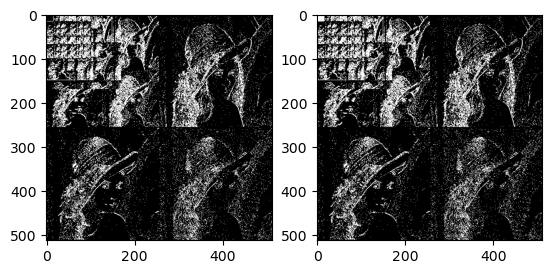

In [24]:
# plot check_filled and bin_img
plt.figure()
plt.subplot(1,2,1)
plt.imshow(check_filled, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(bin_img,  cmap='gray')

In [25]:
recon_img[0:16,0:16] = img[0:16,0:16]

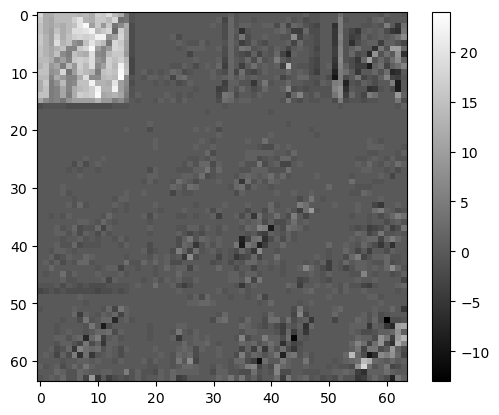

In [26]:
plt.imshow(img[0:64,0:64], cmap='gray')
plt.colorbar()

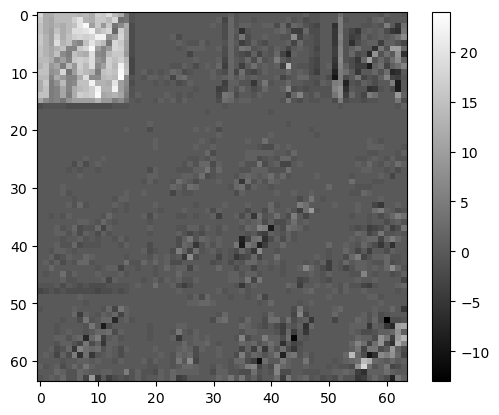

In [27]:
plt.imshow(recon_img[0:64,0:64], cmap='gray')
plt.colorbar()

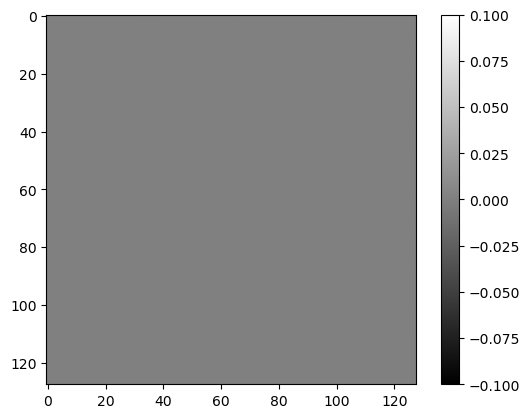

In [28]:
plt.imshow(((recon_img)-img)[0:128,0:128], cmap='gray')
# limit intensity at 10
plt.colorbar()

In [29]:
# calculate psnr between img and recon_img
def psnr(img, recon_img):
    mse = np.mean((img - recon_img)**2)
    return 10 * np.log10(255**2/mse), mse
psnr(img, recon_img)

/tmp/ipykernel_1716553/3287060163.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10(255**2/mse), mse


(inf, 0.0)

In [30]:
# save reconstructed image to npy
np.save('recon_img_ezw.npy', recon_img)

----
test threshold

In [31]:
# img_c = img.copy()
# recon_img[0:16,0:16] = 0